# Similarity renormalization group

__A. J. Tropiano [tropiano.4@osu.edu]__<br/>
__March 25, 2022__

This notebook illustrates SRG evolution by plotting contours of evolving potentials.

_Last update: March 26, 2022_

In [1]:
# Python imports
from matplotlib.offsetbox import AnchoredText
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [2]:
# Imports from A.T. codes
import modules.figures as fg
import modules.labels as lb
from modules.tools import convert_number_to_string
from vnn import Potential

In [3]:
# Run this cell for fancy-looking plots
fg.setup_rc_params(presentation=True)

In [4]:
# Save figures in the following directory
figures_directory = '../figures/srg/'

_To-do:_

* Auto-adjust fontsize for multiplot figures?
* Add docstring to `potential_contours` function.
* Make a function for saving figures?

## Contours of $V(k,k')$

In [5]:
def potential_contours(
        kvnn, channel, kmax, kmid, ntot, generator, lambda_array,
        axes_limits=(0.0,4.0), colorbar_limits=(-1.0,1.0),
        lambda_labels=False, kvnn_label=False, generator_label=False,
        save=False):
    """
    """

    # Initialize Potential class and get momentum values
    potential = Potential(kvnn, channel, kmax, kmid, ntot)
    k_array, _ = potential.load_mesh()
    
    # Store each potential in a dictionary with \lambda as the key
    d = {}
    for lamb in lambda_array:
        # Case for initial potential
        if lamb == np.inf:
            d[lamb] = potential.load_potential('initial')
        else:
            # Case for block-diagonal (assumes \lambda=1, \Lambda_BD=lamb)
            if generator == 'Block-diag':
                d[lamb] = potential.load_potential('srg', generator, 1.0,
                                                   lambda_bd=lamb)
            # Case for band-diagonal generators
            else:
                d[lamb] = potential.load_potential('srg', generator, lamb)
                
    # Set contour color style
    color_style = 'turbo'
    
    # Set limit on interpolation with axes_max
    axes_max = axes_limits[1]
                
    # Add potentials to figure
    f, ax, ax_cbar = fg.plot_contours(k_array, d, axes_max, colorbar_limits,
                                      color_style)

    # Set x- and y-axes
    x_label = "k' [fm" + r'$^{-1}$' + ']'
    y_label = 'k [fm' + r'$^{-1}$' + ']'
    axes_label_size = 16
    f, ax = fg.adjust_axes(f, ax, axes_limits, x_label, y_label,
                           label_size=axes_label_size, invert_y=True)

    # Set colorbar
    colorbar_label = '[fm]'
    colorbar_label_size = 16
    colorbar_tick_size = 14
    f, ax_cbar = fg.add_colorbar(
        f, ax_cbar, colorbar_limits, label=colorbar_label,
        label_size=colorbar_label_size, tick_size=colorbar_tick_size)
    
    # Add \lambda label to each sub-plot?
    if lambda_labels:
        lambda_label_size = 18
        lambda_label_location = 'lower left'
        for i, ilamb in enumerate(lambda_array):
            lambda_label = lb.label_lambda(ilamb, generator)
            anchored_text = AnchoredText(
                lambda_label, loc=lambda_label_location,
                prop=dict(size=lambda_label_size))
            ax[i].add_artist(anchored_text)

    # Add potential label to first sub-plot?
    if kvnn_label:
        kvnn_label = lb.label_kvnn(kvnn)
        kvnn_label_size = 20
        kvnn_label_location = 'upper right'
        anchored_text = AnchoredText(kvnn_label, loc=kvnn_label_location,
                                     prop=dict(size=kvnn_label_size))
        ax[0].add_artist(anchored_text)
        
    # Add generator label to last sub-plot?
    if generator_label:
        generator_label = lb.label_generator(generator)
        generator_label_size = 20
        generator_label_location = 'upper right'
        anchored_text = AnchoredText(
            generator_label, loc=generator_label_location,
            prop=dict(size=generator_label_size))
        ax[-1].add_artist(anchored_text)

    # Save figure?
    if save:
        file_name = (f'potential_contours_kvnn_{kvnn:d}_{channel}'
                     f'_{generator}_lambdas')
        for ilamb in lambda_array:
            if ilamb == np.inf:
                lamb_str = 'inf'
            else:
                lamb_str = convert_number_to_string(ilamb)
            file_name += f'_{lamb_str}'
        file_name = lb.replace_periods(file_name) + '.png'
        f.savefig(figures_directory + file_name)
        
    # TESTING
    print(f'Shape = {ax.shape}')
    print(f'Dimensions = {ax.ndim}')
    print(f'Length = {len(ax)}')
    print(f'Size = {ax.size}')

In [6]:
# Test RKE N4LO 450 MeV in 1P1 channel
kvnn = 111
channel = '1P1'
kmax, kmid, ntot = 10.0, 2.0, 120
lambda_array = np.array([np.inf, 3.0, 2.0, 1.5])
clim = (-0.4, 0.4)

Shape = (4,)
Dimensions = 1
Length = 4
Size = 4


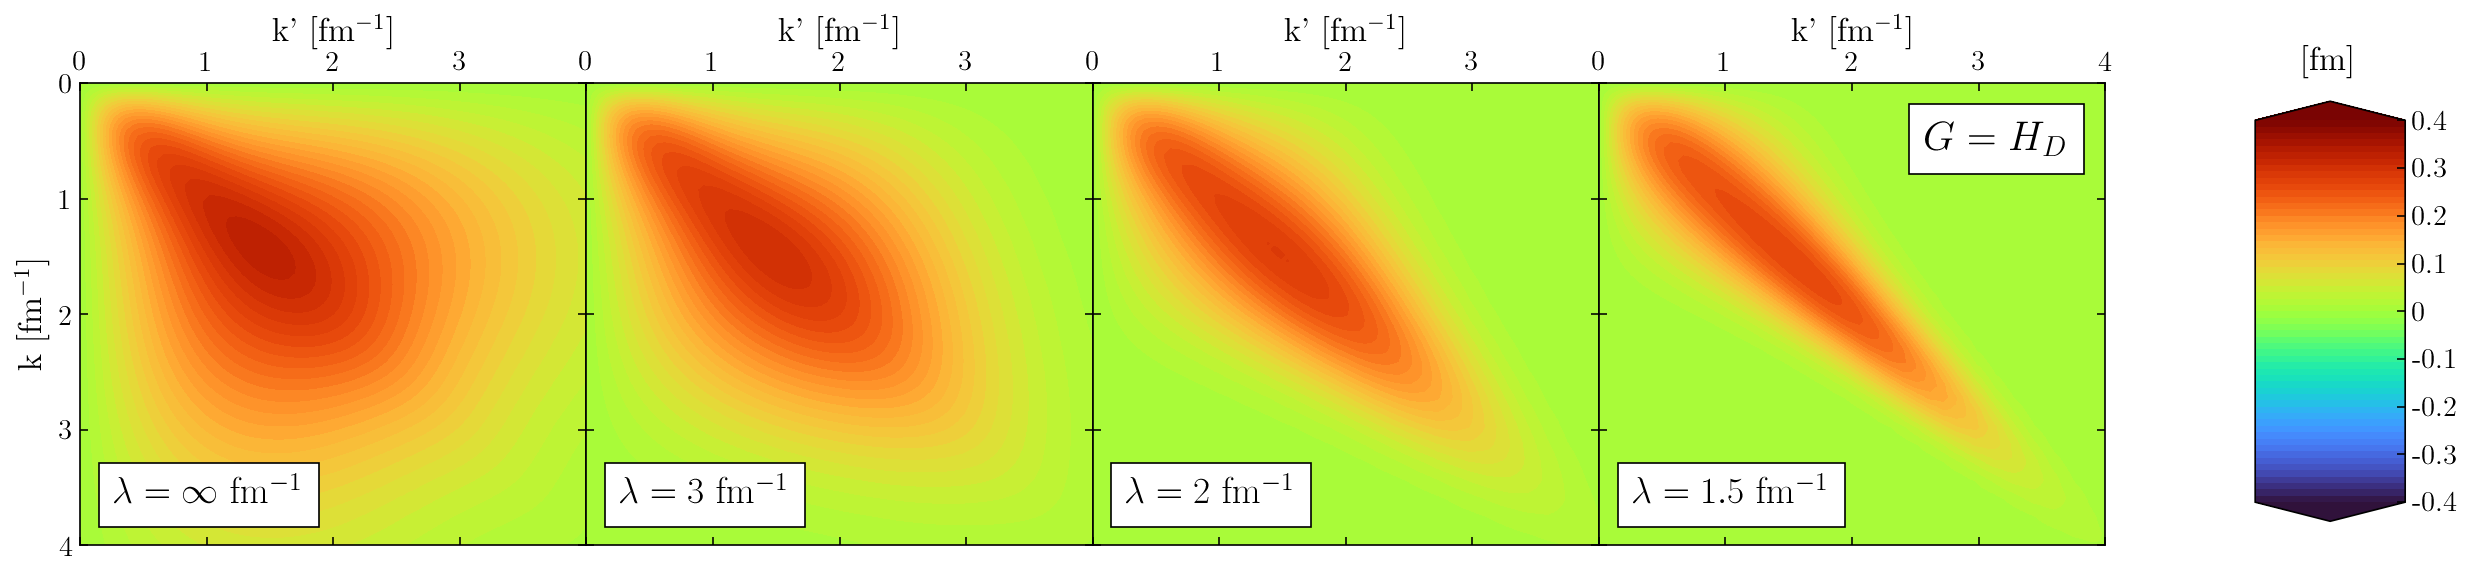

In [7]:
# Band-diagonal generator
potential_contours(
    kvnn, channel, kmax, kmid, ntot, 'Wegner', lambda_array,
    colorbar_limits=clim, lambda_labels=True, generator_label=True,
    save=True)

Shape = (4,)
Dimensions = 1
Length = 4
Size = 4


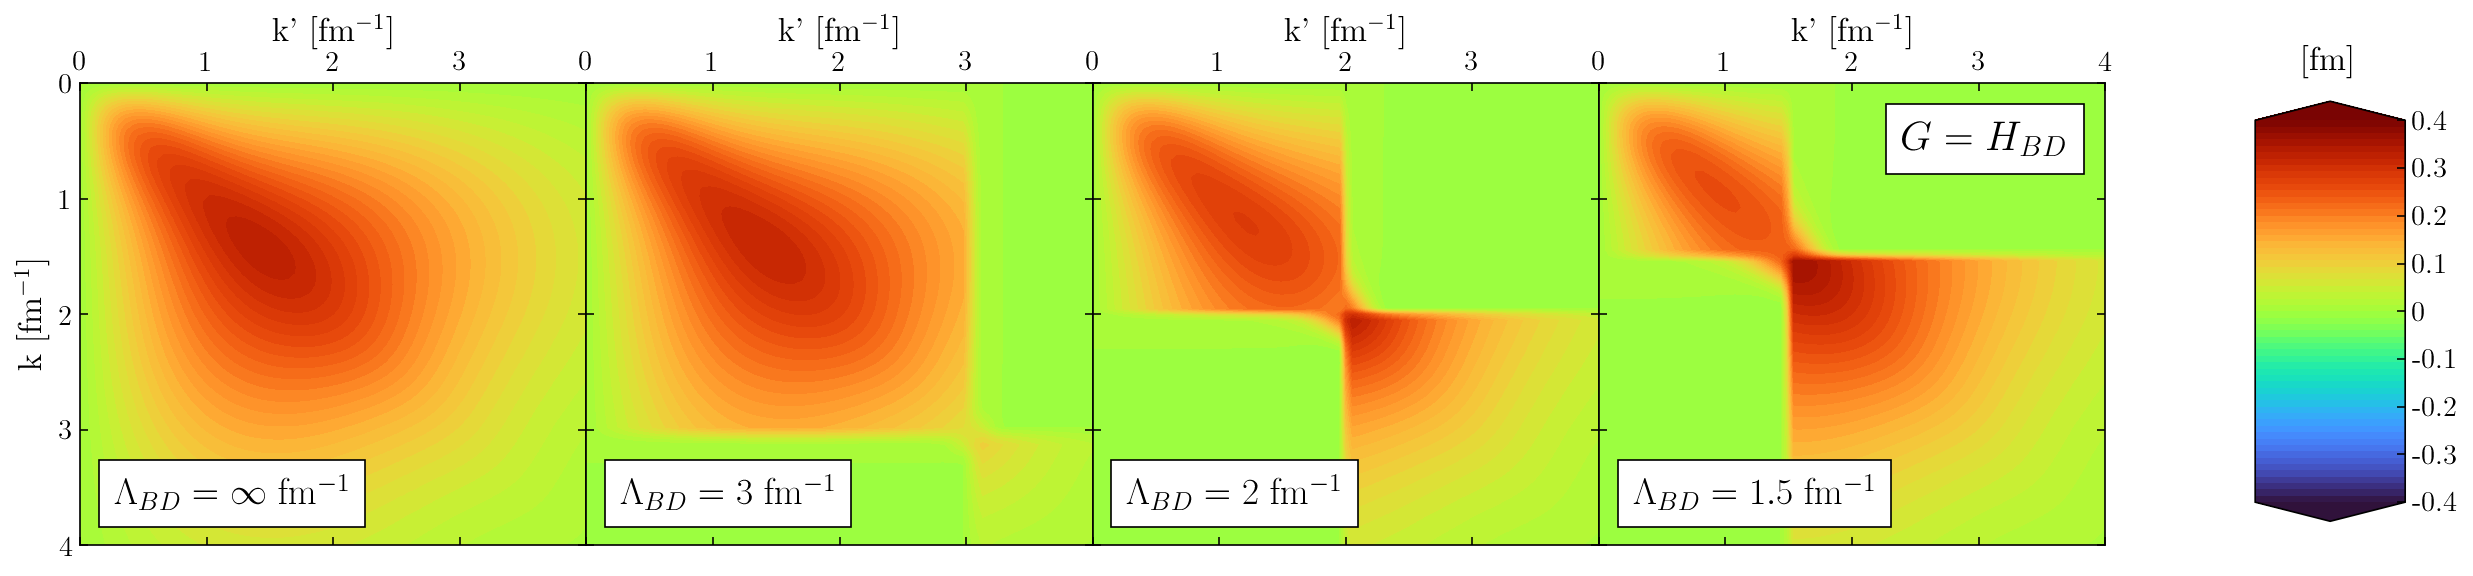

In [8]:
# Block-diagonal generator
potential_contours(
    kvnn, channel, kmax, kmid, ntot, 'Block-diag', lambda_array,
    colorbar_limits=clim, lambda_labels=True, generator_label=True,
    save=True)